In [14]:
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
import folium
from shapely.geometry import Polygon, Point
from folium.plugins import HeatMap
from shapely.ops import polygonize
import geopandas
import folium

In [ ]:
for e in G.nodes:
    # print(e)
    # print( G[e])
    # break
    G.nodes[e]['x']=float(G.nodes[e]['x'])
    G.nodes[e]['y']=float(G.nodes[e]['y'])

In [5]:
place = "Manhattan, United States"
graph = ox.graph_from_place(place, network_type="drive")
len(graph)
# %%
#Streets
nodes, streets = ox.graph_to_gdfs(graph)
streets.head()
# %%

style = {'color': '#F7DC6F', 'weight':'1'}
m = folium.Map([40.730610, -73.935242],
               zoom_start=15,
               tiles="CartoDb dark_matter")
folium.GeoJson(streets, style_function=lambda x: style).add_to(m)
m.save("streets.html")
m

In [50]:
chunksize = 10 ** 6  # number of rows per chunk
for chunk in pd.read_csv('../data/yellow_tripdata_2015-01-06.csv', chunksize=chunksize):
    df=chunk
    break

In [ ]:
df=df.iloc[0:500,:]

In [52]:
df['geometrypickup'] = [Point(xy) for xy in zip(df.pickup_longitude, df.pickup_latitude)]
df['geometrydropoff'] = [Point(xy) for xy in zip(df.dropoff_longitude, df.dropoff_latitude)]

In [24]:
polygons = geopandas.GeoSeries(polygonize(streets.geometry))

<Axes: >

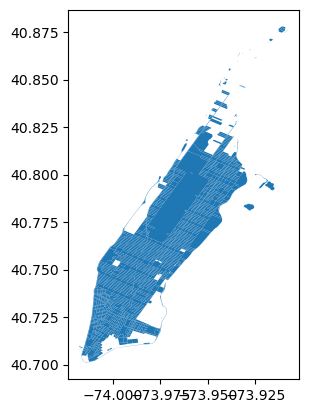

In [51]:
polygons.plot()

In [56]:
# df[df.apply(lambda x : polygons.within(x['geometrypickup']).any() and polygons.within(x['geometrydropoff']).any(),axis=1)]
#trying to filter for taxi trips that strt and end in manhattan

In [57]:
nodes

y          x          highway  street_count  ref  \
osmid                                                                   
42421728     40.798048 -73.960044  traffic_signals             3  NaN   
42421731     40.798654 -73.961474  traffic_signals             4  NaN   
42421737     40.799244 -73.962873  traffic_signals             4  NaN   
42421741     40.800429 -73.965691  traffic_signals             4  NaN   
42421745     40.801398 -73.967996  traffic_signals             4  NaN   
...                ...        ...              ...           ...  ...   
10128931543  40.820630 -73.958472              NaN             3  NaN   
10128931544  40.820384 -73.957906              NaN             1  NaN   
10220180386  40.743230 -74.008724  traffic_signals             3  NaN   
10282972213  40.713221 -74.011143              NaN             1  NaN   
10316226053  40.705805 -74.013357              NaN             3  NaN   

                               geometry  
osmid                                    
42421728     POINT (-73.96004 40.79805)  
42421731     POINT (-73.96147 40.79865)  
42421737     POINT (-73.96287 40.79924)  
42421741     POINT (-73.96569 40.80043)  
42421745     POINT (-73.96800 40.80140)  
...                                 ...  
10128931543  POINT (-73.95847 40.82063)  
10128931544  POINT (-73.95791 40.82038)  
10220180386  POINT (-74.00872 40.74323)  
10282972213  POINT (-74.01114 40.71322)  
10316226053  POINT (-74.01336 40.70580)  

[4569 rows x 6 columns]

In [ ]:
y_target=df.iloc[1,:]['pickup_longitude']
x_target=df.iloc[1,:]['pickup_latitude']
# nodes['distance'] = np.sqrt((nodes['x'] - x_target) ** 2 + (nodes['y'] - y_target) ** 2)


# sort dataframe by distance and return closest point
closest_point = nodes.sort_values('distance').iloc[0]

print(closest_point)

In [70]:
nodes.apply(lambda x : x['geometry'].distance(df['geometrypickup'][0]),axis=1).sort_values().index[0]

42437339

In [71]:
closest=[]
for point1 in df['geometrypickup']:
    closest.append( nodes.apply(lambda x : x['geometry'].distance(point1),axis=1).sort_values().index[0])


In [73]:
df['osmpickup']=closest

/tmp/ipykernel_20161/4173165636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['osmpickup']=closest


In [74]:
closestdrop=[]
for point1 in df['geometrydropoff']:
    closestdrop.append( nodes.apply(lambda x : x['geometry'].distance(point1),axis=1).sort_values().index[0])
df['osmdropoff']=closestdrop

/tmp/ipykernel_20161/2585488966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['osmdropoff']=closestdrop


In [103]:
df=(df.merge(nodes[['geometry']].add_suffix('_osmpickup'),left_on='osmpickup',right_on='osmid')).merge(nodes[['geometry']].add_suffix('_osmdropoff'),left_on='osmdropoff',right_on='osmid').drop(['geometrypickup','geometrydropoff'],axis=1)

In [112]:
df.geometry_osmdropoff[0].x

-73.9740139

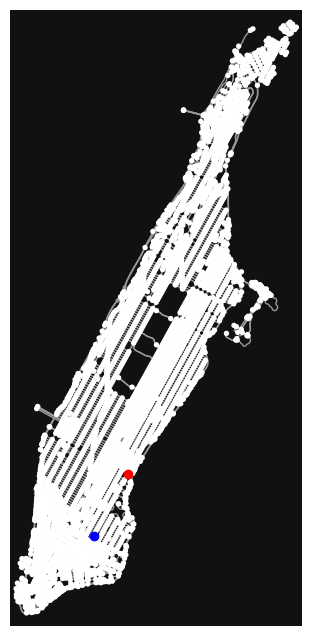

In [118]:
import matplotlib.pyplot as plt

fig,ax=ox.plot_graph(graph,show=False,close=False)
ax.scatter(df.geometry_osmdropoff[0].x,df.geometry_osmdropoff[0].y,c='red')
ax.scatter(df.geometry_osmpickup[0].x,df.geometry_osmpickup[0].y,c='blue')
plt.show()

In [132]:
commuters=[]
for _,row in df[['osmpickup','osmdropoff']].iterrows():
    try:
        path=nx.shortest_path(graph,source=row['osmpickup'],target=row['osmdropoff'])
        commuters.append(path)
    except:
        continue

In [134]:
len(commuters)

498